In [1]:
import galarp as grp
from galarp import InterpolatedWind, InterpolatedDensity

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
from matplotlib import animation

from scipy import stats
from scipy.interpolate import interp1d

from astropy.modeling.models import Gaussian1D, custom_model
from astropy.modeling.fitting import LevMarLSQFitter

In [2]:
orbits = grp.OrbitContainer.load("temp/orbits_JZ_dup.grp")

print(orbits)


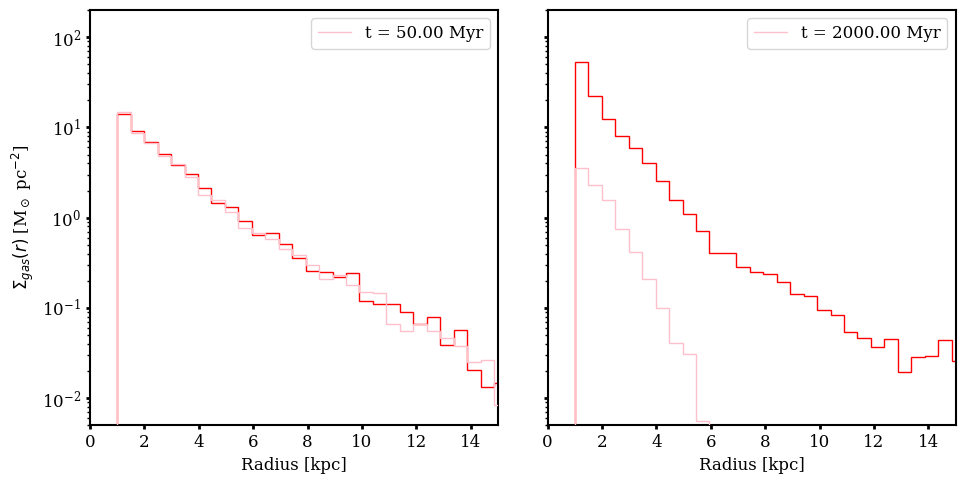

In [49]:
def radial_density(orbits, **kwargs):
    x, y, z, vx, vy, vz = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2 + z**2)

    rmin, rmax = kwargs.get("rmin", 1), kwargs.get("rmax", 50)
    bins = np.linspace(rmin, rmax, 100)

    indices = np.linspace(0, len(r) - 1, 10, dtype=int)
    
    densities  = []
    for i in indices:
        r_hist, bin_edges = np.histogram(r[i], bins=bins)
        v_spherical = (4 * np.pi / 3) * (bin_edges[1:]**3 - bin_edges[:-1]**3) * u.kpc**3
        density = (r_hist * orbits.metadata["M_CLOUD"] / v_spherical).to(u.g / u.cm**3)
        densities.append(density)
        plt.stairs(density.value, bin_edges, label = f"t = {orbits.data.t[i]:.2f}")

    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return densities


def radial_surface_density(orbits, **kwargs):
    x, y, z, vx, vy, vz = orbits.get_orbit_data(transposed=False)

    r = np.sqrt(x**2 + y**2)

    rmin, rmax = kwargs.get("rmin", 1), kwargs.get("rmax", 50)
    bins = np.linspace(rmin, rmax, 100)

    indices = np.linspace(0, len(r) - 1, 5, dtype=int)

    densities  = []
    for i in indices:
        r_hist, bin_edges = np.histogram(r[i], bins=bins)
        v_circular = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2) * u.kpc**2
        
        surface_density = (r_hist * orbits.metadata["M_CLOUD"] / v_circular).to(u.Msun / u.pc**2)
        densities.append(surface_density)
        plt.stairs(surface_density.value, bin_edges, label = f"t = {orbits.data.t[i]:.2f}")
    
    plt.ylabel("$\Sigma_{gas}(r)$ [M$_\odot$ pc$^{-2}$]")
    plt.xlabel("Radius [kpc]")

    plt.xlim(0, 15)
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()


def radial_surface_density_leading_trailing(orbits, **kwargs):
    x, y, z, vx, vy, vz = orbits.get_orbit_data(transposed=False)

    leading, trailing = x < 0, x > 0
    
    r = np.sqrt(x**2 + y**2)

    rmin, rmax = kwargs.get("rmin", 1), kwargs.get("rmax", 50)
    bins = np.linspace(rmin, rmax, 100)

    indices = kwargs.get("indices", np.linspace(0, len(r) - 1, 10, dtype=int))


    def get_surface_density(a):
        r_hist, bin_edges = np.histogram(a, bins=bins)
        v_circular = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2) * u.kpc**2
        
        surface_density = (r_hist * orbits.metadata["M_CLOUD"] / v_circular).to(u.Msun / u.pc**2)
        return bin_edges, surface_density

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=kwargs.get("figsize", (10, 5)))

    for i, index in enumerate(indices):
        this_leading, this_trailing = r[index][x[index] < 0], r[index][x[index] > 0]


        bin_edges, surface_density_leading = get_surface_density(this_leading)
        bin_edges, surface_density_trailing = get_surface_density(this_trailing)

        ax[i].stairs(surface_density_leading.value, bin_edges, label = f"t = {orbits.data.t[index]:.2f}", 
                   color="pink", zorder=3)
        ax[i].stairs(surface_density_trailing.value, bin_edges, 
                   color="red")

        ax[i].set(xlabel="Radius [kpc]", yscale="log",  xlim=(0, 15), ylim=(0.005, 200))
        ax[i].legend()
    ax[0].set_ylabel("$\Sigma_{gas}(r)$ [M$_\odot$ pc$^{-2}$]")

    plt.tight_layout()

    outname = kwargs.get("outname", None)
    if outname is not None:
        plt.savefig(outname)
    else:
        plt.show()

#densities = radial_density(orbits)
densities = radial_surface_density_leading_trailing(orbits, indices = [10, 400],
                                                     outname="figures/surface_density_leading_trailing.png")